# Algorytmy geometryczne, ćwiczenie 2

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie+,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie
#### Funkcje generujące punkty

In [3]:
%matplotlib notebook
from random import uniform
from math import cos, sin, pi, sqrt


def pointsInInterval(s, t, n):
    return [(uniform(s, t), uniform(s, t)) for _ in range(n)]


def pointsInCircle(c, r, n):  # c - center, r - radius, n - number of points
    result = []
    for _ in range(n):
        fi = uniform(0, 2 * pi)
        x = c[0] + r * cos(fi)
        y = c[1] + r * sin(fi)
        result.append((x, y))
    return result

Funkcje `pointsInInterval` oraz `pointsInCircle` są dokładnie takie same, jak w poprzednim ćwiczeniu. Pierwsza generuje punkty z danego zakresu na prostokącie, druga - na okręgu

In [4]:
def findLineParams(a, b):  # find A and B in y = Ax + B
    (x1, y1), (x2, y2) = a, b
    A = (y1 - y2) / (x1 - x2)
    B = y1 - A * x1
    return A, B


def intervalLength(a, b):
    return sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)


def makeProbabilityArray(arr):
    n = len(arr)
    lengths = [intervalLength(arr[i % n], arr[(i + 1) % n]) for i in range(n)]
    circum = sum(lengths)
    return [(arr[i % n], arr[(i + 1) % n], lengths[i] / circum) for i in range(n)]


def weightedRandomSelect(arr):  # we assume, that probabilities add to 1
    randDouble = uniform(0, 1)
    for (a, b, prob) in arr:
        randDouble -= prob
        if randDouble < 0:
            return a, b


def pointInInterval(a, b):  # a, b - points, s,t - range, n - number of points
    if a[0] == b[0]:
        s = min(a[1], b[1])
        t = max(a[1], b[1])
        return a[0], uniform(s, t)

    s, t = min(a[0], b[0]), max(a[0], b[0])
    A, B = findLineParams(a, b)

    x = uniform(s, t)
    y = A * x + B
    return x, y


def pointsInRectangle(arr, n):  # arr - array with 4 tuples representing corners of the rectangle
    probArr = makeProbabilityArray(arr)  # probArr has all the edges
    # of the rectangle in form (corner1, corner2, probability)
    result = []
    for i in range(n):
        a, b = weightedRandomSelect(probArr)  # a, b - ends of random edge
        result.append(pointInInterval(a, b))

    return result

Funkcja generująca punkty w prostokącie jest nieco bardziej skomplikowana i do stworzenia tego zbioru potrzebne jest kilka pomocniczych funkcji.

W uproszczeniu funkcja `pointsInRectangle` bierze tablicę z 4 punktami prostokąta, następnie  tworzy tablice `probArr`, w której przechowywane jest oprócz punktów danego boku prawdopodobieństwo jego wybrania (obliczana jako długośćBoku/obwód). Następnie wybierany jest bok wg wagi (za pomocą `weightedRandomSelect`), a następnie losowany jest punkt na danym boku. Procedura powtarzana jest n razy.

In [5]:
def pointsInHalfSquareWithDiagonals(x, y, n1, n2):  #points are only generated on the X and Y axes and on the diagonals.
    # x, y - the coordinates of the corner opposite to corner (0,0)
    #n1, n2 - number of points on axes and diagonals
    a, b, c, d = (x, 0), (0,0), (0, y), (x, y) 

    arr = [(a,b, n1), (b,c, n1), #boki
           (a,c, n2), (b,d, n2)] #przekątne
    result = [a,b,c,d]
    for u, v, n in arr:
        for _ in range(n):
            result.append(pointInInterval(u,v))

    return result


Funkcja `pointsInHalfSquareWithDiagonals` przyjmuje współrzędne najdalszego od (0,0) wierzchołka oraz liczbę punktów na osiach i przekątnych. 

Funkcja najpierw oblicza pozostałe wierzchołki kwadratu i dodaje je do listy wynikowej. Następnie z pomocą funkcji `pointInInterval` losuje po n1 punktów na każdej z osi oraz po n2 punktów na obu przekątnych.

Funkcja została napisana w taki sposób, aby można było jej użyć do wygenerowania analogicznie punktów na prostokącie.

In [6]:
rectangle = [(-10, 10), (-10,-10), (10,-10), (10,10)]

defaultPointSets = [pointsInInterval(-100, 100, 100),
                    pointsInCircle((0,0), 10, 100),
                    pointsInRectangle(rectangle, 100),
                    pointsInHalfSquareWithDiagonals(10, 10, 20, 25)]

visualPointSets = [pointsInInterval(-100, 100, 15),
                    pointsInCircle((0,0), 10, 20),
                    pointsInRectangle(rectangle, 30),
                    pointsInHalfSquareWithDiagonals(10, 10, 10, 10)]

colors = ["blue",   #inactive
          "green",  #in the convex hull
          "gold", #on stack
          "red"]  #currently processed point  

`defaultPointSets` to zbiory punktów wygenerowane zgodnie z 1. punktem planu ćwiczenia. Są to zbiory kontrolne, które sprawdzają poprawność działania algorytmu.

`visualPointSets` to zbiory punktów analogiczne do tych w `defaultPointSets`, które są mniej liczne, by ułatwić wizualizację działania algorytmu

`colors` - tablica z odpowiednimi kolorami

### Wizualizacja zbiorów punktów

<IPython.core.display.Javascript object>


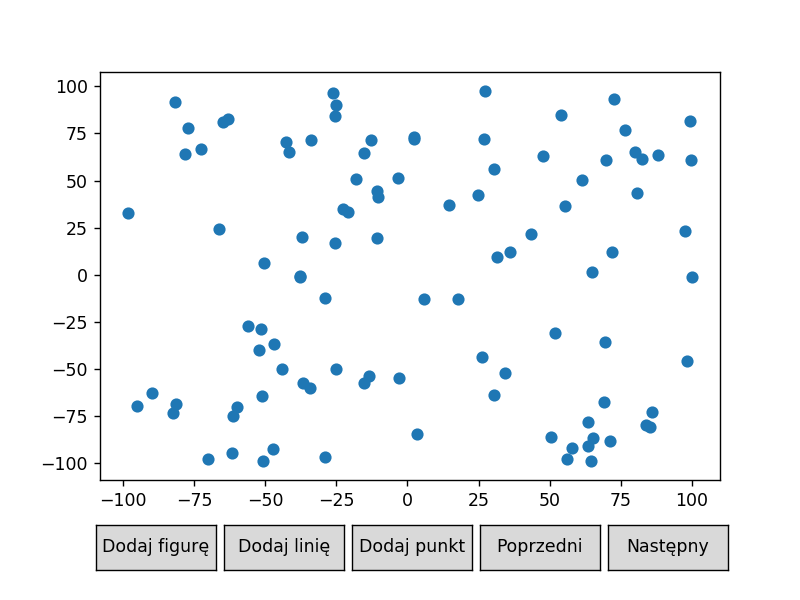

In [7]:
scenes = [Scene([PointsCollection(pointSet)]) for pointSet in defaultPointSets] +\
         [Scene([PointsCollection(pointSet)]) for pointSet in visualPointSets]
plot = Plot(scenes = scenes)
plot.draw()

### Funkcja wizualizujaca wyniki
Funkcja `drawResults` rysuje na bazie zbioru punktów, funkcji oraz wyniku tej funkcji jej otoczkę wypukłą. Jest ona oddzielona od klasy `visualizer`, ponieważ obiekt tej klasy jest tworzony jedynie dla zbiorów z `visualPointSets`, a obrazować wynik nalezy dla wszystkich zbiorów. Omawiana funkcja jest również znacznie prostsza od klasy `visualizer`

In [8]:
def drawResults(pointSets, convFunc):  #convFunc - convex function - funkcja zwaracająca punkty otoczki
    result = [convFunc(pSet) for pSet in pointSets]
    lines = [[[res[i], res[(i+1)%len(res)]] for i in range(len(res))] for res in result]
    
    scenes = [Scene([PointsCollection(pointSets[i], color=colors[0]),
                     PointsCollection(result[i], color=colors[1])],
                   [LinesCollection(lines[i], color=colors[1])])
              for i in range(len(result))]
    return Plot(scenes = scenes)

### Klasa wizualizująca wyniki
Klasa `Visualizer` ma za zadanie stworzyć wizualizację kolejnych kroków w trakcie działania algorytmu.

Jej opis działania jest prosty: wystarczy stworzyć obiekt tej klasy, któremu przy inicjalizacji przekazujemy tablice stanu programu. Są one następnie aktualizowane w trakcie działania algorytmu (w ciele obiektu przechowywane są jedynie ich wskaźniki). Za każdym razem, gdy chcemy stworzyć nową scenę, wywołujemy metodę `makeScene`.
Zestaw scen można uzyskać dzięki funkcji `getScenes`.

Dodatkowo funkcja oblicza, gdzie w danym momencie przechodzą linie otoczki i również zapisuje to w danej scenie.

In [9]:
class Visualizer:
    def __init__(self, arrays):
        self.scenes = [Scene([PointsCollection(arrays[0][:], color=colors[0])])]
        self.results = arrays     #we do not copy, because change in `arrays` automatically changes `self.results`
    
    def _makeLines(self, pointSet, join_last = False):
        if len(pointSet) < 2:  return [] 
        
        n = len(pointSet)
        lines = [[pointSet[i], pointSet[i+1]] for i in range(n-1)]
        if join_last:
            lines.append((pointSet[n-1], pointSet[0]))   #double brackets because of a tuple
        elif lines[0][0] == lines[-1][-1]:     #when the last point is joined with the first one and join_last is False, we need to delete the unnecessary line
            lines.pop()
        return lines
    
    def makeScene(self, end=False):
        points = [PointsCollection(self.results[i][:], color=colors[i]) for i in range(len(self.results))]
        lines = [LinesCollection(self._makeLines(self.results[1]+ self.results[2] + self.results[3], join_last=end), color=colors[1])]
        self.scenes.append(Scene(points, lines))
        
    
    def getScenes(self):
        return self.scenes
        

## Algorytm Grahama
### Funkcje pomocnicze
#### Wyznacznik
W ćwiczeniu używamy wyznacznika 3x3, który wypadł najlepiej w poprzednim sprawozdaniu

In [10]:
def det3x3(a,b,c):
    s1 = a[0]*b[1] + b[0]*c[1] + c[0]*a[1]
    s2 = a[1]*b[0] + b[1]*c[0] + c[1]*a[0]
    return s1 - s2

#### Przyporządkowanie
Funkcja przyporządkowuje dany punkt c jako znajdujący się zgodnie ze wskazówkami zegara, przeciwnie, czy też za współliniowy z prostą wektora ab. Epsilon = 10^(-13), ponieważ taka wartość przyniosła najlepsze rezultaty dla danego wyznacznika w poprzednim sprawozdaniu.
Funkcja zwraca liczbę -1 dla punktów CW, 1 dla CCW oraz 0 dla współliniowych

In [11]:
def divide(a,b,c):
    eps = 10**(-13)

    det = det3x3(a, b, c)   # computing the determinant of given interval and the point c
    if det < -eps:           # c is clockwise to the interval - it's on its right 
        return -1
    elif det > eps:          # c is counterclockwise to the interval - it's on its left
        return 1
    else:                    # c is within the "epsilon range" - collinear
        return 0

#### Sortowanie algorytmem quickSort
Zmodyfikowana wersja algorytmu quicksort sortuje względem kąta wektora (p0, p) z osią x.

In [12]:
def partition(P, start, stop, p0):
    i = start
    for j in range(start, stop):
        if divide(p0, P[stop], P[j]) < 0:
            P[i],P[j]=P[j],P[i]
            i += 1
    P[stop],P[i] = P[i], P[stop]
    return i

def quickSort(P, start, stop, p0):
    if start < stop:
        pivot = partition(P, start, stop, p0)
        quickSort(P, start, pivot - 1, p0)
        quickSort(P, pivot + 1, stop, p0)

#### Sortowanie algorytmem mergeSort
Zmodyfikowana wersja algorytmu mergesort sortuje względem kąta wektora (p0, p) z osią x. Została tu zaimplementowana jako alternatywa dla quicksorta, ponieważ quicksort dla dużej ilości punktów współliniowych staje się kwadratowy i mocno opóźnia algorytm. Mergesort nie jest jednak używany jako domyślny, ponieważ w ogólnym przypadku, quicksort jest szybszym algorytmem.

In [13]:
def merge(A, p, q, r, p0):
    n1 = q-p+1
    n2 = r-q
    left = A[p:q+1]
    right = A[q+1:r+1]
    i = 0
    j = 0

    while i < n1 and j < n2:
        if divide(p0, left[i], right[j]) > 0:
            A[p+i+j] = left[i]
            i += 1
        else:
            A[p+i+j] = right[j]
            j += 1

    while i < n1:
        A[p+i+j] = left[i]
        i += 1
    while j < n2:
        A[p+i+j] = right[j]
        j += 1

def mergeSort(A, p, r, p0):
    if p < r:
        q = (r + p)//2
        mergeSort(A, p, q, p0)
        mergeSort(A, q+1, r, p0)
        merge(A,p,q,r, p0)

#### Usuwanie punktów współliniowych
Funkcja `removeCollinear` składa się zasadniczo z dwóch etapów: usuwanie punktów współliniowych względem p0 oraz usuwanie punktów współliniowych w samej liście P. Jest to zobrazowane dwoma podobnymi funkcjami:

Funkcja `removeCollinearP0` sprawdza współliniowość punktów w liście P. Sprawdzane są jedynie pary sąsiadujących punktów, ponieważ P jest już posortowane za pomocą powyższej `funkcji quickSort` Jest to usuwanie punktów współliniowych tylko względem punktu P0 i par punktów ze zbioru.
Funkcja `removeShorter` usuwa krótszy z dwóch punktów. Uzywa ona funkcji `intervalLength` napisaną wyżej

Funkcja `removeCollinearSet` sprawdza współliniowość trójek w liście P. Każda współliniowa trójka jest sortowana i środkowy element jest usuwany z listy P. Algorytm ma działanie liniowe, jednak czasem może dopuścić pojedyncze zbiory punktów współliniowych (np. na przecięciu przekątnych w zbiorze D zostawia cztery punkty na osi `y = -x`) Jednak usunięcie wszystkich punktów współliniowych potrzebowałoby czasu O(n^3) porównań, co znacząco zwolniłoby działanie algorytmu.

In [14]:
def removeShorter(P, i, p0):
    if intervalLength(P[i], p0) < intervalLength(P[i+1], p0):
        del P[i]
    else:
        del P[i+1] 
        
        
def removeCollinear(P, p0):
    def removeCollinearP0(P, p0):
        n = len(P)
        i = 0
        for _ in range(n-1):
            if divide(p0, P[i], P[i+1]) == 0:
                removeShorter(P, i, p0)
            else:
                i += 1

    def removeCollinearSet(P):
        n = len(P)
        i = 0
        for _ in range(n-2):
            tmpArr = P[i:(i+3)]
            if len(tmpArr) == 3 and divide(tmpArr[0], tmpArr[1], tmpArr[2]) == 0:
                tmpArr.sort(key=lambda x: x[0])
                tmpArr.sort(key=lambda x: x[1])
                for j in range(i, i+3):    #deleting the middle point
                    if j < len(P) and P[j] == tmpArr[1]:
                        del P[j]
            else:
                i += 1
                
    removeCollinearP0(P, p0)
    removeCollinearSet(P)

### Znajdowanie punktu p0
Funkcja `findp0` znajduje punkt P0 i go zwraca

In [15]:
def findp0(P):
    y_min = min(P, key=lambda point: point[1])
    smallestYs = list(filter(lambda y: y[1] <= y_min[1], P))
    return min(smallestYs, key=lambda point: point[0])

### Algorytm Grahama

In [16]:
def Graham(P):  # P - points set
    p0 = findp0(P)

    Pcopy = P[:]  # copying the original table so we do not modify the original points set
    Pcopy.remove(p0)
    quickSort(Pcopy, 0, len(Pcopy) - 1, p0)
    removeCollinear(Pcopy, p0)

    stack = [p0, Pcopy[0], Pcopy[1]]
    for point in Pcopy[2:]:
        P1, P2 = stack[-2], stack[-1]
        while divide(P1, P2, point) < 0 and len(stack) > 2:
            stack.pop()
            P1, P2 = stack[-2], stack[-1]
        stack.append(point)

    return stack

### Algorytm Grahama z mergeSortem

In [17]:
def GrahMS(P):  # P - points set
    p0 = findp0(P)

    Pcopy = P[:]  # copying the original table so we do not modify the original points set
    Pcopy.remove(p0)
    mergeSort(Pcopy, 0, len(Pcopy) - 1, p0)
    removeCollinear(Pcopy, p0)

    stack = [p0, Pcopy[0], Pcopy[1]]
    for point in Pcopy[2:]:
        P1, P2 = stack[-2], stack[-1]
        while divide(P1, P2, point) < 0 and len(stack) > 2:
            stack.pop()
            P1, P2 = stack[-2], stack[-1]
        stack.append(point)

    return stack

### Zbiory domyślne

<IPython.core.display.Javascript object>


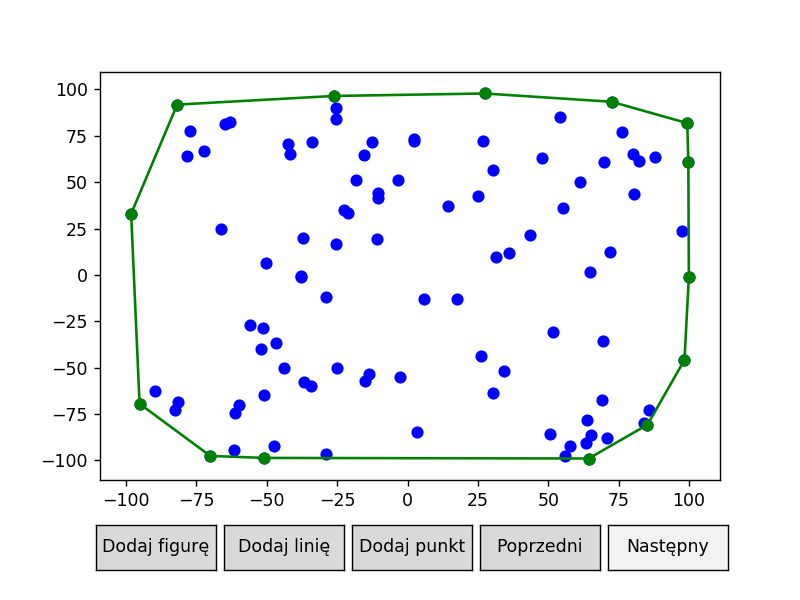

In [17]:
plot = drawResults(defaultPointSets, Graham)
plot.draw()

### Zbiory ilustracyjne
### Algorytm Grahama - wersja z wizualizerem
W celu większej czytelności - kod podstawowy został przepisany poniżej, lecz w wersji z wizualizerem

In [19]:
def GrahamShow(P):  #P - points set
    stateArr = [[] for _ in range(4)]
    
    p0 = findp0(P)     
    Pcopy = P[:]
       
    stateArr[0] = Pcopy #copying the original table so we do not modify the original points set
    stateArr[1].append(p0)
    vis = Visualizer(stateArr)
    
    Pcopy.remove(p0)
    
    quickSort(Pcopy, 0, len(Pcopy) - 1, p0)
    removeCollinear(Pcopy, p0)
    vis.makeScene()
    
    stack = [p0, Pcopy[0], Pcopy[1]]
    
    stateArr[2] = stack
    vis.makeScene()
    
    for point in Pcopy[2:]:
        stateArr[3] = [point]
        P1, P2 = stack[-2], stack[-1]
        flag = True
        while divide(P1, P2, point) < 0 and len(stack) > 2:
            stack.pop()
            P1, P2 = stack[-2], stack[-1]
            vis.makeScene()
            flag = False
        
        if flag: vis.makeScene()
        stack.append(point)
        
        
    stateArr[0] = P
    stateArr[1] = stack
    stateArr[2] = []
    stateArr[3] = []
    vis.makeScene(end=True)
    
    
    
    return Plot(scenes=vis.getScenes())

#### Zbiór 1

<IPython.core.display.Javascript object>


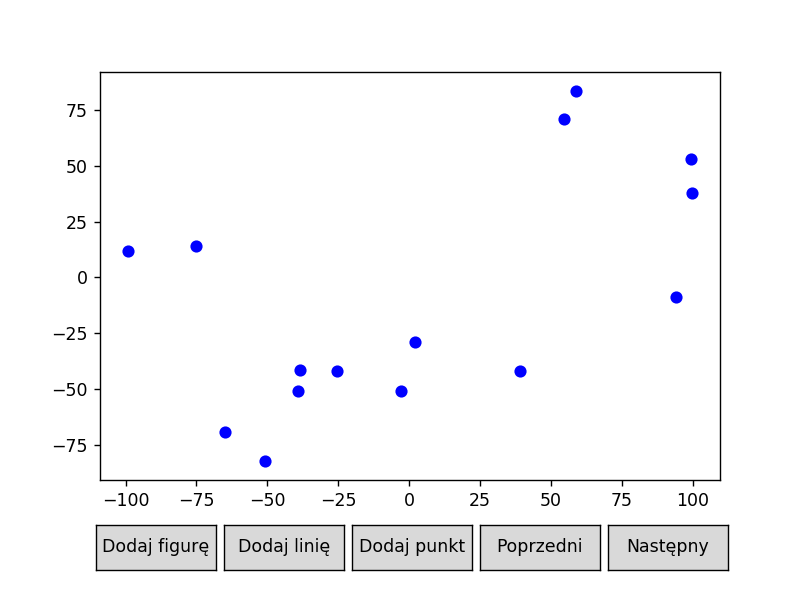

In [20]:
plot = GrahamShow(visualPointSets[0])
plot.draw()

#### Zbiór 2

<IPython.core.display.Javascript object>


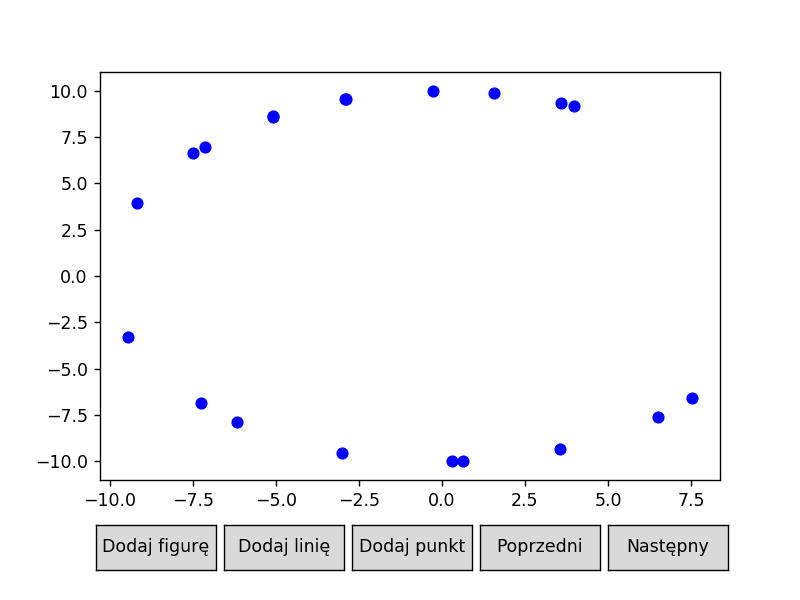

In [22]:
plot = GrahamShow(visualPointSets[1])
plot.draw()

#### Zbiór 3

<IPython.core.display.Javascript object>


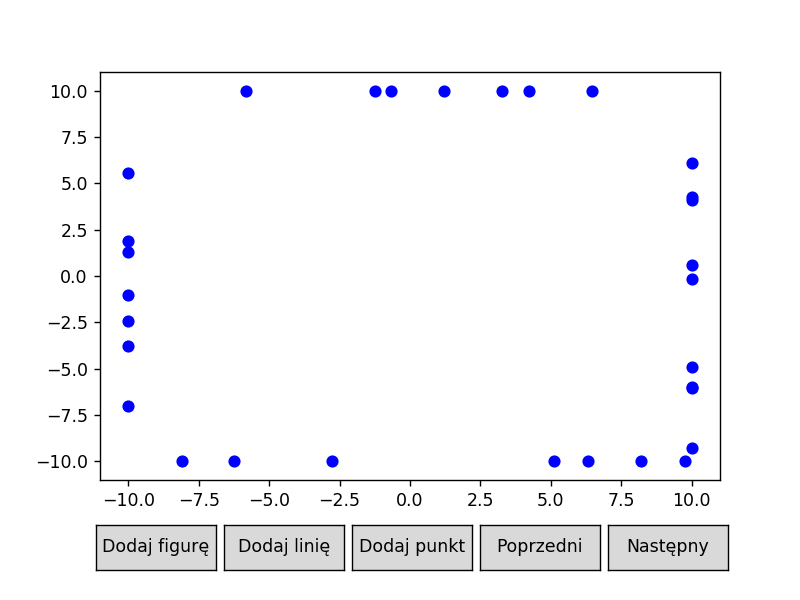

In [23]:
plot = GrahamShow(visualPointSets[2])
plot.draw()

#### Zbiór 4

<IPython.core.display.Javascript object>


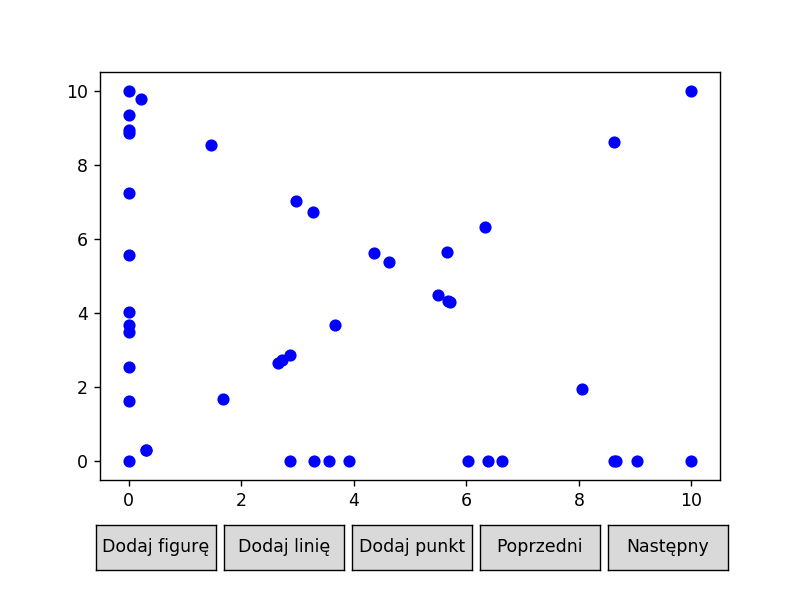

In [24]:
plot = GrahamShow(visualPointSets[3])
plot.draw()

## Algorytm Jarvisa
### Funkcje pomocnicze
#### Znajdowanie najmniejszego punktu
Kluczowa dla algorytmu jest funkcja `findMinPoint`, która znajduje punkt o najmniejszej współrzędnej kątowej względem danego punktu.
Jest ona analogiczna do zachłannej funkcji znajdowania minimum, co sprawia, że jej wykonanie jest asymptotycznie liniowe.
W przypadku remisów, funkcja wybiera dalszy od p0 punkt

In [21]:
def findMinPoint(P, p0):
    min_ind = 0
    for i in range(len(P)):
        if divide(p0, P[min_ind], P[i]) < 0:
            min_ind = i
        elif divide(p0, P[min_ind], P[i]) == 0:  #if points are collinear, we take the one further from p0
            if intervalLength(p0, P[i]) > intervalLength(p0, P[min_ind]):
                min_ind = i
    p_min = P[min_ind]
    del P[min_ind]
    return p_min

### Algorytm Jarvisa

In [22]:
def Jarvis(P):
    Pcopy = P[:]
    p0 = findp0(Pcopy)
    convex = [p0]
    p = p0
    while True:
        tmp = findMinPoint(Pcopy, p)
        if tmp != p0:
            convex.append(tmp)
        p = tmp
        if p == p0:
            return convex

#### Zbiory domyślne

<IPython.core.display.Javascript object>


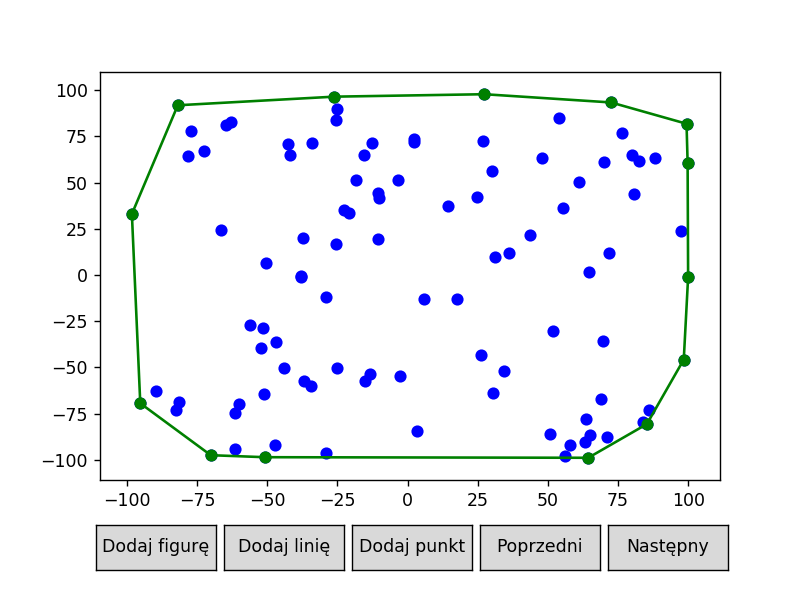

In [23]:
plot = drawResults(defaultPointSets, Jarvis)
plot.draw()

### Zbiory ilustracyjne
### Algorytm Jarvisa - wersja z wizualizatorem

In [24]:
def JarvisShow(P):
    stateArr = [[] for _ in range(4)]
    
    Pcopy = P[:]
    stateArr[0] = Pcopy
    vis = Visualizer(stateArr)
    
    p0 = findp0(Pcopy)
    convex = [p0]
    p = p0
    
    
    stateArr[1] = convex
    vis.makeScene()
    
    while True:
        tmp = findMinPoint(Pcopy, p)
        stateArr[3] = [tmp]
        vis.makeScene()
        
        if tmp != p0:
            convex.append(tmp)
        else:
            stateArr[3] = []
            vis.makeScene(end=True)
            return Plot(vis.getScenes())  #umieszczenie "return" wczesniej niz w oryginalnej wersji algorytmu zapobiega niepotrzebnym scenom na koniec
        p = tmp
            

#### Zestaw 1

<IPython.core.display.Javascript object>


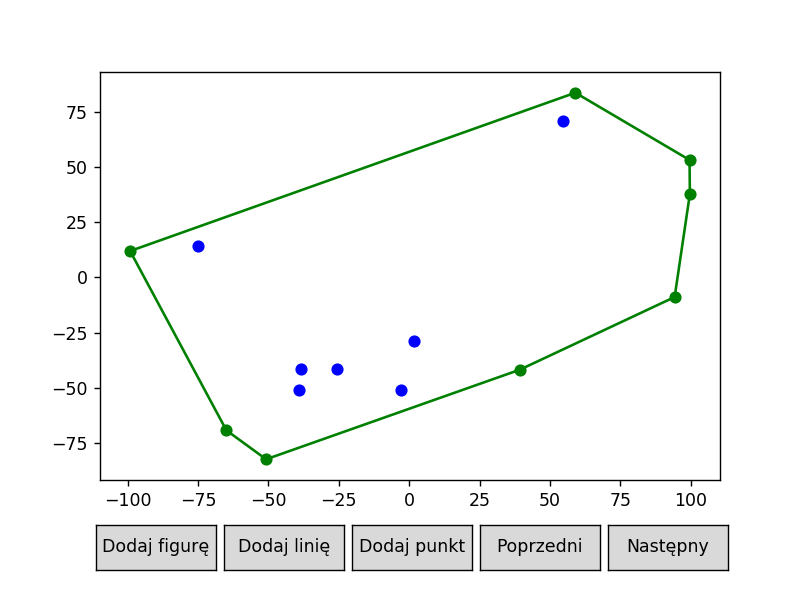

In [25]:
plot = JarvisShow(visualPointSets[0])
plot.draw()

#### Zestaw 2

<IPython.core.display.Javascript object>


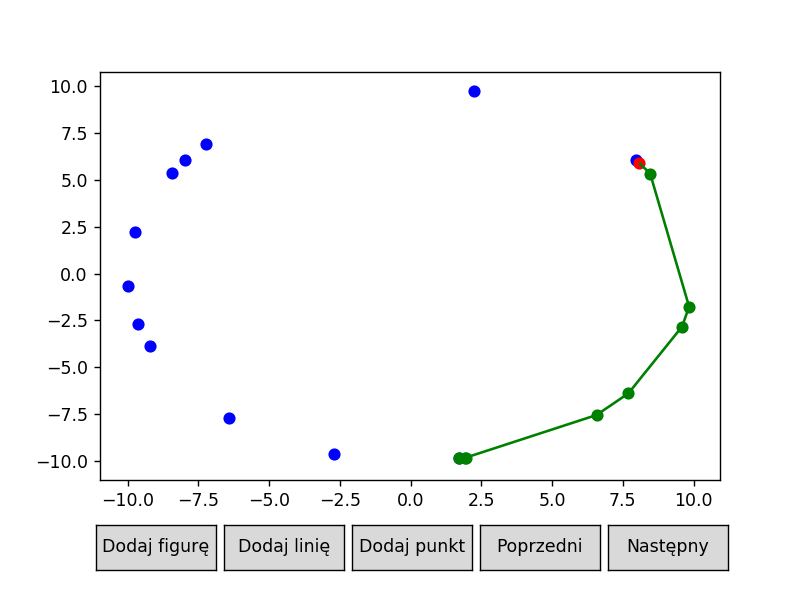

In [26]:
plot = JarvisShow(visualPointSets[1])
plot.draw()

#### Zestaw 3

<IPython.core.display.Javascript object>


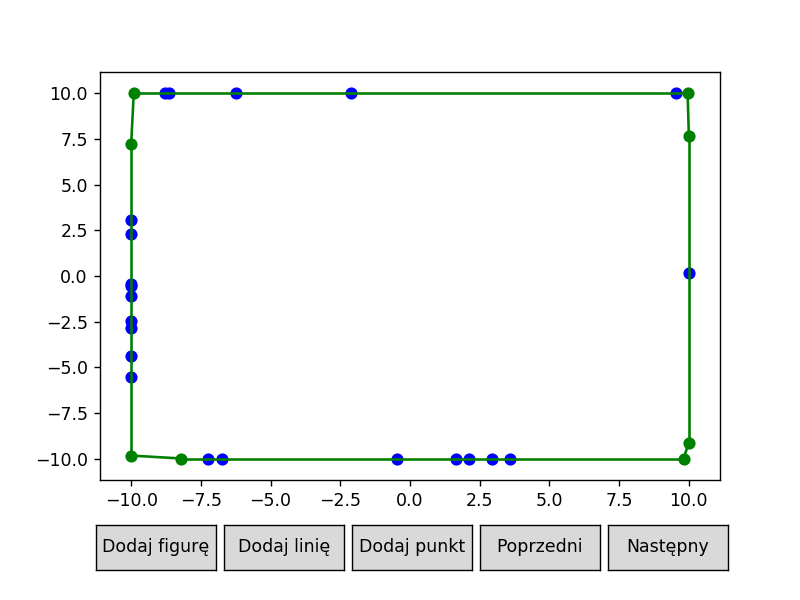

In [37]:
plot = JarvisShow(visualPointSets[2])
plot.draw()

#### Zestaw 4

<IPython.core.display.Javascript object>


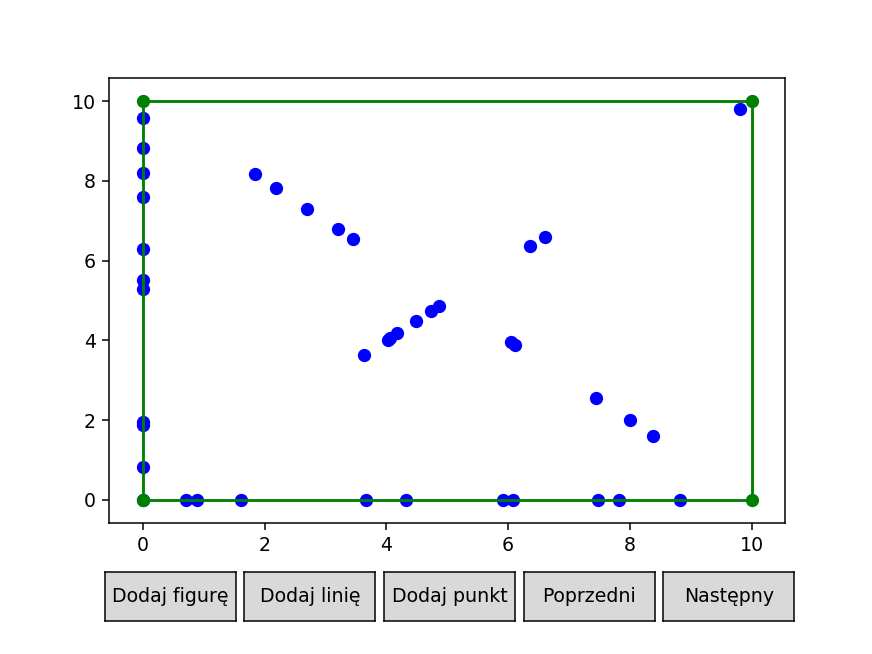

In [27]:
plot = JarvisShow(visualPointSets[3])
plot.draw()

### Sprawdzenie czasu działania algorytmu
Ponieważ dane potrzebne do wygenerowania punktów były różne i ich wybór przebiegał na drodze eksperymentu przeprowadzającego doświadczenie, poniższy kod nie jest umieszczony w osobnej funkcji i wywoływany w kolejnych komórkach zeszytu, lecz w takiej, zwięzłej formie.

Wyniki dla każdego typu zbioru umieszczone zostały w sprawozdaniu, jednak twórca gorąco zachęca czytającego niniejszy notebook do samodzielnego eksperymentowania z liczbami, typami zbioru i sprawdzaniem algorytmów. Życzę udanej zabawy! :)

In [31]:
import time

def checkTime(convFunc, pointSets):
    result = []
    for pSet in pointSets:
        a = time.time()
        convFunc(pSet)
        b = time.time()
        result.append(round(b-a, 4))
    return result

timeStamps = []
numberOfPoints = list(range(1000, 5001, 1000))
functions = [Graham, Jarvis]
rectangle = [(-10, 10), (-10,-10), (10,-10), (10,10)]
pointSets = [pointsInCircle((0,0), 10, i) for i in numberOfPoints]

for func in functions:
    timeStamps.append(checkTime(func, pointSets))

for i in range(len(functions)):
    print(f'{functions[i].__name__}:', end='\t')
    for tStamp in timeStamps[i]:
        print(f'{tStamp}', end='\t')
    print()

Graham:	0.0222	0.0157	0.0469	0.0535	0.0625	
Jarvis:	0.6581	2.5929	5.9032	10.2833	16.0503	
